# Texas Dataset

In [1]:
from torch_geometric.datasets import WebKB
from torch_geometric.transforms import NormalizeFeatures


Texas_dataset = WebKB(root='./dataset/Texas', name='Texas', transform=NormalizeFeatures())

In [2]:
Texas_data = Texas_dataset[0]
Texas_data

Data(x=[183, 1703], edge_index=[2, 325], y=[183], train_mask=[183, 10], val_mask=[183, 10], test_mask=[183, 10])

## Visualization

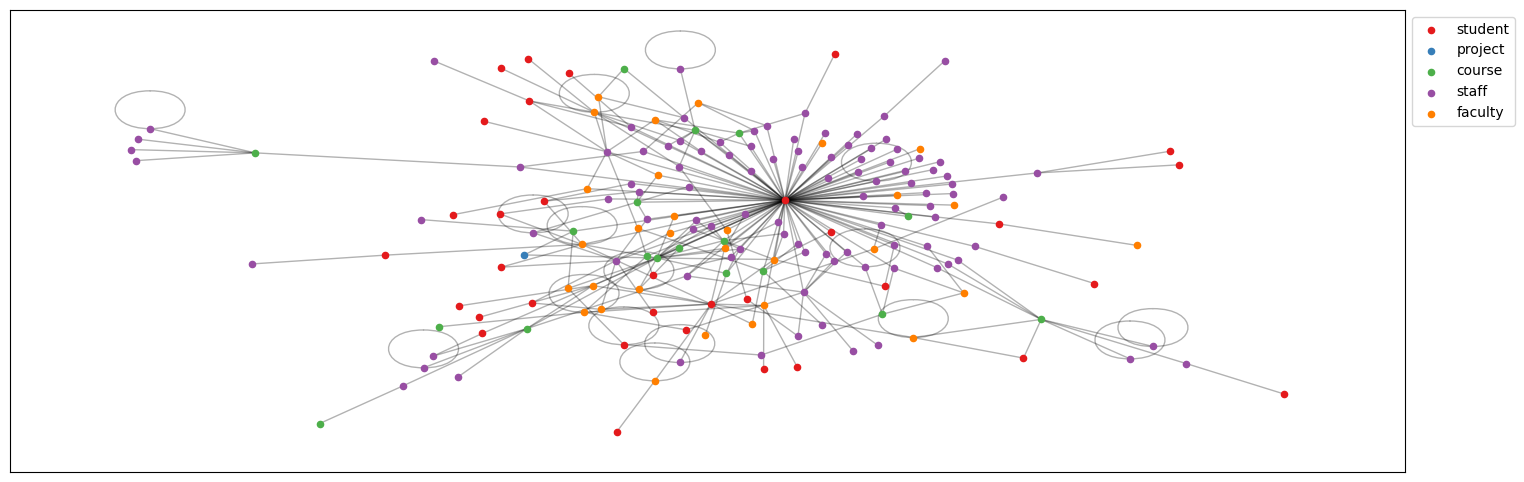

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

label_dict = {
    0: "student",
    1: "project",
    2: "course",
    3: "staff",
    4: "faculty"}

plt.figure(figsize=(18,6))

G = to_networkx(Texas_data, to_undirected=True)
node_color = []
nodelist = [[], [], [], [], []]
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']
labels = Texas_data.y
for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)
pos = nx.spring_layout(G, seed = 42)
labellist = list(label_dict.values())
for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(G, pos, nodelist=n, node_size = 20, node_color = colorlist[num], label=l)
nx.draw_networkx_edges(G, pos, alpha = 0.3, edge_color = 'black')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig("texas.pdf", dpi = 300, bbox_inches="tight")

# Transformations

In [5]:
import torch
import copy
import networkx as nx
import random
import numpy as np
from torch_geometric.transforms import VirtualNode, AddLaplacianEigenvectorPE
from torch_geometric.utils import from_networkx, to_networkx, to_undirected, to_dense_adj, degree
from torch_geometric.data import InMemoryDataset
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from scipy.sparse import csgraph
from scipy.sparse import csr_matrix


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
###Visual Node
def apply_vn(data):
    vn_data = copy.deepcopy(data)  # Make a deep copy to preserve the original dataset
    transform = VirtualNode()

    vn_transform = transform(vn_data)

    return vn_transform


###Centrality
def add_centrality_to_node_features(Texas_data, centrality_measure='degree'):
    data = copy.deepcopy(Texas_data)
    G = to_networkx(data, node_attrs=['x'], to_undirected=True)

    # Compute the centrality measure
    if centrality_measure == 'degree':
        centrality = nx.degree_centrality(G)
    elif centrality_measure == 'closeness':
        centrality = nx.closeness_centrality(G)
    elif centrality_measure == 'betweenness':
        centrality = nx.betweenness_centrality(G)
    elif centrality_measure == 'eigenvector':
        if not nx.is_connected(G):
        # Handle connected components separately
            centrality = {}
            for component in nx.connected_components(G):
                subgraph = G.subgraph(component)
                sub_centrality = nx.eigenvector_centrality(subgraph, max_iter=500, tol=1e-4)
                centrality.update(sub_centrality)
        else:
            centrality = nx.eigenvector_centrality(G, max_iter=500, tol=1e-4)
    else:
        raise ValueError(f'Unknown centrality measure: {centrality_measure}')
    
    # Convert centrality to tensor and add as node feature
    centrality_values = list(centrality.values())
    centrality_tensor = torch.tensor(centrality_values, dtype=torch.float).view(-1, 1)
    centrality_tensor = (centrality_tensor - centrality_tensor.mean()) / (centrality_tensor.std() + 1e-8)
    data.x = torch.cat([data.x, centrality_tensor], dim=-1)

    return data

###Distance Encoding
def distance_encoding_node_augmentation(Texas_data):
    data = copy.deepcopy(Texas_data)
    G = to_networkx(data, node_attrs=['x'], to_undirected = True)
    num_nodes = data.num_nodes

    # Initialize the distance matrix with infinity
    distance_matrix = [[float('inf')] * num_nodes for _ in range(num_nodes)]
    shortest_paths = dict(nx.all_pairs_shortest_path_length(G))
    
    # Populate the distance matrix with actual shortest path lengths
    for i in range(num_nodes):
        distance_matrix[i][i] = 0  # Distance to self is 0
        if i in shortest_paths:
            for j, d in shortest_paths[i].items():
                distance_matrix[i][j] = d

    # Convert the distance matrix to a tensor
    distance_tensor = torch.tensor(distance_matrix, dtype=torch.float)
    
    # Add average distance to node features
    finite_distances = torch.where(distance_tensor == float('inf'), torch.tensor(float('nan')), distance_tensor)
    average_distance = torch.nanmean(finite_distances, dim=1).view(-1, 1)  # Use nanmean to ignore infinities
    data.x = torch.cat([data.x, average_distance], dim=1)
    
    return data



def distance_encoding_edge_rewiring(Texas_data):
    data = copy.deepcopy(Texas_data)
    G = to_networkx(data, node_attrs=['x'], to_undirected=True)
    G_transformed = G.copy()

    connected_components = list(nx.connected_components(G))
    shortest_paths = {}

    # Compute shortest paths for each connected component
    for component in connected_components:
        subgraph = G.subgraph(component)
        component_paths = dict(nx.all_pairs_shortest_path_length(subgraph))
        shortest_paths.update(component_paths)


    nodes = list(G.nodes)
    for i in nodes:
        for j in nodes:
            if i != j:
                if G.has_edge(i, j):
                    G_transformed[i][j]['edge_attr'] = [1]
                else:
                    if i in shortest_paths and j in shortest_paths[i]:
                        distance = shortest_paths[i][j]
                    else:
                        distance = 1e9  # Replace inf with a large finite value
                    G_transformed.add_edge(i, j, edge_attr=[distance])
            else:
                if G.has_edge(i, i):
                    G_transformed[i][i]['edge_attr'] = [0]
                

    # Convert back to PyG data
    new_data = from_networkx(G_transformed, group_node_attrs=['x'], group_edge_attrs=['edge_attr'])
    new_data.edge_attr = torch.tensor(new_data.edge_attr, dtype=torch.float)

    # Check for invalid values
    if torch.isnan(new_data.edge_attr).any() or torch.isinf(new_data.edge_attr).any():
        raise ValueError("Edge attributes contain invalid values!")

    # Preserve other attributes
    new_data.y = data.y
    return new_data



###Subgraph Extraction
def extract_local_subgraph_features(Texas_data, radius=2):
    data = copy.deepcopy(Texas_data)
    
    G = to_networkx(data, node_attrs=['x'], to_undirected=True)

    # Initialize a list to store subgraph features for each node
    subgraph_sizes = []
    subgraph_degrees = []
    
    for node in G.nodes():
        # Extract the ego graph (subgraph) around the node
        subgraph = nx.ego_graph(G, node, radius=radius)
        
        # Example feature 1: Size of the subgraph (number of nodes)
        subgraph_size = subgraph.number_of_nodes()
        subgraph_sizes.append(subgraph_size)
        
        # Example feature 2: Average degree of the subgraph
        subgraph_degree = np.mean([d for n, d in subgraph.degree()])
        subgraph_degrees.append(subgraph_degree)
        
    # Convert the features to tensors and add them as node features
    subgraph_sizes_tensor = torch.tensor(subgraph_sizes, dtype=torch.float).view(-1, 1)
    subgraph_degrees_tensor = torch.tensor(subgraph_degrees, dtype=torch.float).view(-1, 1)
    
    # Concatenate the new features to the existing node features
    data.x = torch.cat([data.x, subgraph_sizes_tensor, subgraph_degrees_tensor], dim=-1)
    
    return data
    

def canonicalize_eigenvectors(eigenvectors):
    """
    Canonicalize eigenvectors by fixing their signs for consistency.
    This ensures that isomorphic graphs will have the same eigenvectors.
    """
    for i in range(eigenvectors.shape[1]):
        if eigenvectors[0, i] < 0:  # Flip sign if the first element is negative
            eigenvectors[:, i] = -eigenvectors[:, i]
    return eigenvectors

def add_canonicalized_laplacian_pe_pyg(Texas_data, k=3, max_features=None):
    """
    Add canonicalized Laplacian positional encoding to a PyG data object.

    Args:
        Texas_data (torch_geometric.data.Data): PyG data object.
        k (int): Number of Laplacian eigenvectors to compute.
        max_features (int): Total desired node feature dimensions after encoding.
                            If None, it will automatically match the existing feature dimensions + k.

    Returns:
        data (torch_geometric.data.Data): PyG data object with Laplacian PE appended to node features.
    """
    data = copy.deepcopy(Texas_data)
    # Step 1: Convert PyG graph to NetworkX graph
    G = to_networkx(data, to_undirected=True)

    # Step 2: Compute sparse adjacency matrix
    adj = nx.to_scipy_sparse_array(G, format='csr').astype(np.float64)

    # Step 3: Convert adjacency matrix to sparse format
    adj_sparse = csr_matrix(adj)

    # Step 4: Compute normalized Laplacian matrix
    laplacian = csgraph.laplacian(adj_sparse, normed=True)

    # Step 5: Handle small graphs
    num_nodes = adj_sparse.shape[0]
    if num_nodes <= 1:
        raise ValueError(f"Graph has too few nodes ({num_nodes}) for Laplacian PE.")
    num_eigenvectors = min(k, num_nodes - 1)  # Ensure k < num_nodes

    # Step 6: Compute the smallest eigenvectors using sparse methods
    eigenvalues, eigenvectors = eigsh(laplacian, k=num_eigenvectors, which='SM')  # Smallest magnitude eigenvalues

    # Step 7: Canonicalize eigenvectors
    eigenvectors = canonicalize_eigenvectors(torch.tensor(eigenvectors, dtype=torch.float))

    # Step 8: Determine max_features
    existing_features_dim = data.x.shape[1] if 'x' in data else 0
    max_features = max_features if max_features is not None else existing_features_dim + k

    # Step 9: Pad eigenvectors if necessary
    padding = torch.zeros((eigenvectors.shape[0], max_features - num_eigenvectors - existing_features_dim))
    eigenvectors = torch.cat([eigenvectors, padding], dim=1)

    # Step 10: Append the eigenvectors as new node features
    if 'x' in data:
        # Pad existing features if necessary
        num_padding = max_features - existing_features_dim - k
        existing_padding = torch.zeros((data.x.shape[0], num_padding))
        data.x = torch.cat([data.x, existing_padding, eigenvectors], dim=1)
    else:
        data.x = eigenvectors

    return data
    

###Add Extra Node on Each Edge
def add_extra_node_on_each_edge(Texas_data):

    # Deep copy to avoid modifying the original data
    data = copy.deepcopy(Texas_data)
    
    # Convert PyG data to NetworkX graph
    G = to_networkx(data, node_attrs=['x'])

    # Original number of nodes
    num_original_nodes = G.number_of_nodes()

    # Prepare lists for new features
    edges = list(G.edges(data=True))
    new_node_features = []
    new_node_labels = []  # If data.y is node-level, collect labels for new nodes

    for u, v, edge_data in edges:
        # Skip self-loops
        if u == v:
            continue

        # Remove the original edge
        G.remove_edge(u, v)

        # Create a new node with a feature as the mean of connected nodes' features
        new_node_id = num_original_nodes + len(new_node_features)
        new_node_feature = (data.x[u] + data.x[v]) / 2
        new_node_features.append(new_node_feature)
        
        # Add the new node
        G.add_node(new_node_id, x=new_node_feature)

        # Add edges from the new node to the original nodes
        G.add_edge(u, new_node_id)
        G.add_edge(new_node_id, v)

        # If `data.y` is node-level, assign a placeholder label (e.g., 0)
        if data.y.size(0) == num_original_nodes:  # Node-level labels
            new_node_labels.append(0)  # Placeholder label for new nodes

    # Convert back to PyG Data object
    modified_data = from_networkx(G)

    # Update node features
    if new_node_features:  # Check if new nodes were added
        modified_data.x = torch.cat([data.x, torch.stack(new_node_features)], dim=0)
    else:
        modified_data.x = data.x  # No new nodes added

    # Update node-level labels if applicable
    if data.y.size(0) == num_original_nodes:  # Node-level labels
        modified_data.y = torch.cat([data.y, torch.tensor(new_node_labels, dtype=data.y.dtype)], dim=0)
    else:
        # Assume graph-level labels; keep `data.y` unchanged
        modified_data.y = data.y

    return modified_data



def count_3_star(G):
    """Count 3-star graphlets for each node."""
    star_counts = {}
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        degree = len(neighbors)
        # Count the number of 3-combinations of neighbors
        star_counts[node] = max(0, (degree * (degree - 1) * (degree - 2)) // 6)
    return star_counts

def count_tailed_triangle(G):
    """Count tailed triangle graphlets for each node."""
    tail_counts = {node: 0 for node in G.nodes()}
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        for neighbor in neighbors:
            for other in neighbors:
                if neighbor != other and G.has_edge(neighbor, other):
                    for extra in G.neighbors(node):
                        if extra not in {neighbor, other}:
                            tail_counts[node] += 1
    return tail_counts

def count_4_cycle(G):
    """Count 4-cycle graphlets for each node in an undirected graph G."""
    cycle_counts = {node: 0 for node in G.nodes()}
    
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        # Iterate over all unique neighbor pairs
        for i, neighbor1 in enumerate(neighbors):
            for neighbor2 in neighbors[i + 1:]:
                # Find common neighbors of neighbor1 and neighbor2
                shared_neighbors = set(G.neighbors(neighbor1)).intersection(G.neighbors(neighbor2))
                # Add the count of shared neighbors to node's 4-cycle count
                cycle_counts[node] += len(shared_neighbors)
    
    # Each 4-cycle is counted 4 times (once per node in the cycle)
    cycle_counts = {node: count // 4 for node, count in cycle_counts.items()}
    
    return cycle_counts

def graphlet_based_encoding_pyg(Texas_data):
    """
    Add graphlet-based features (3-star, triangle, tailed triangle, 4-cycle) to node features in PyG.

    Args:
        data: PyG Data object.

    Returns:
        data: PyG Data object with graphlet-based features added.
    """
    data = copy.deepcopy(Texas_data)
    # Convert PyG graph to NetworkX
    G = to_networkx(data, to_undirected=True)

    # Count graphlets
    triangle_counts = nx.triangles(G)  # Triangle counts
    star_counts = count_3_star(G)  # 3-star graphlets
    tail_counts = count_tailed_triangle(G)  # Tailed triangles
    cycle_counts = count_4_cycle(G)  # 4-cycles

    # Combine features into tensors
    num_nodes = data.num_nodes
    triangle_tensor = torch.tensor([triangle_counts[node] for node in range(num_nodes)], dtype=torch.float).view(-1, 1)
    star_tensor = torch.tensor([star_counts[node] for node in range(num_nodes)], dtype=torch.float).view(-1, 1)
    tail_tensor = torch.tensor([tail_counts[node] for node in range(num_nodes)], dtype=torch.float).view(-1, 1)
    cycle_tensor = torch.tensor([cycle_counts[node] for node in range(num_nodes)], dtype=torch.float).view(-1, 1)

    # Concatenate all graphlet features
    graphlet_features = torch.cat([triangle_tensor, star_tensor, tail_tensor, cycle_tensor], dim=1)

    # Add to node features
    if data.x is not None:
        data.x = torch.cat([data.x, graphlet_features], dim=1)
    else:
        data.x = graphlet_features

    return data



In [7]:
Texas_original = copy.deepcopy(Texas_data)
Texas_vn = apply_vn(Texas_data)
Texas_deg = add_centrality_to_node_features(Texas_data, centrality_measure='degree')
Texas_clo = add_centrality_to_node_features(Texas_data, centrality_measure='closeness')
Texas_bet = add_centrality_to_node_features(Texas_data, centrality_measure='betweenness')
Texas_eig = add_centrality_to_node_features(Texas_data, centrality_measure='eigenvector')
Texas_de_n = distance_encoding_node_augmentation(Texas_data)
Texas_de_g = distance_encoding_edge_rewiring(Texas_data)
Texas_se = extract_local_subgraph_features(Texas_data, radius=3)
Texas_ge = add_canonicalized_laplacian_pe_pyg(Texas_data, k=3, max_features=1706)  # max_features = original number of featurs + added features
Texas_exN = add_extra_node_on_each_edge(Texas_data)
Texas_gle = graphlet_based_encoding_pyg(Texas_data)

/var/folders/ml/8lnl08s13tj5jbb_fkzftzfw0000gn/T/ipykernel_7708/1050315317.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_data.edge_attr = torch.tensor(new_data.edge_attr, dtype=torch.float)


Analyzing dataset: No Transformation
Analyzing dataset: Virtual Node
Analyzing dataset: Degree Centrality
Analyzing dataset: Closeness Centrality
Analyzing dataset: Betweenness Centrality
Analyzing dataset: Eigenvector Centrality
Analyzing dataset: Distance Encoding - Node
Analyzing dataset: Distance Encoding - Edge
Analyzing dataset: Graph Encoding
Analyzing dataset: Subgraph Extraction
Analyzing dataset: Extra Node
Analyzing dataset: Graphlet-Based Encoding


/var/folders/ml/8lnl08s13tj5jbb_fkzftzfw0000gn/T/ipykernel_7708/167451822.py:127: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(all_results))  # Define colormap with enough colors for all transformations


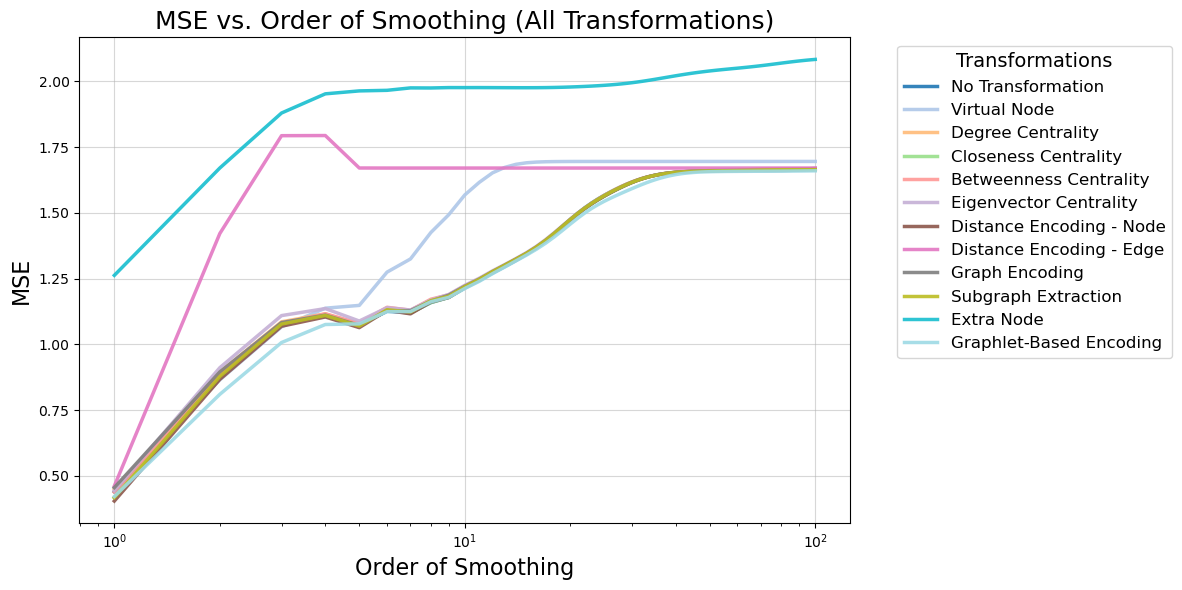

In [8]:
from sklearn.decomposition import PCA
from scipy.interpolate import make_interp_spline
from matplotlib import cm
from scipy.signal import savgol_filter

# Close all previous plots
plt.close('all')
np.random.seed(0)

# Parameters
kmax = 100  # Maximum smoothing iterations
p = 50      # PCA dimensionality reduction
lbd = 1e-7  # Ridge regularization

# Function to analyze oversmoothing for a single graph
def analyze_oversmoothing(data, name):
    """
    Analyze oversmoothing using iterative feature propagation for a single graph.
    
    Args:
        data: PyTorch Geometric `Data` object.
        name: Name of the dataset/transformation.
        savefig: Whether to save figures as PDF files.
    
    Returns:
        acc: List of MSE values across smoothing iterations.
    """
    # Convert to NetworkX graph and extract largest connected component
    G = to_networkx(data, to_undirected=True)
    Gcc = max(nx.connected_components(G), key=len)
    Gcc = G.subgraph(Gcc).copy()
    ind = list(Gcc.nodes)
    n = len(ind)

    # Create adjacency matrix
    W = nx.to_numpy_array(Gcc)
    W = W + np.eye(n)  # Add self-loops
    D = W.sum(axis=0)
    W = W / D[:, None]  # Normalize adjacency matrix

    # Perform PCA on node features
    pca = PCA(n_components=p)
    X = data.x[ind].cpu().numpy()  # Extract node features for nodes in the largest connected component
    X = pca.fit_transform(X)
    X -= X.mean(axis=0)[None, :]  # Center features

    # Extract labels corresponding to the largest connected component
    label_map = {node: idx for idx, node in enumerate(ind)}
    Y = np.zeros(n, dtype=np.float64)
    for node in Gcc.nodes():
        Y[label_map[node]] = data.y[node].item()
    Y -= Y.mean()  # Center labels

    # Initialize variables for smoothing
    WX = X
    acc = []  # MSE values

    for k in range(kmax):
        if k == 0 or k == 10 or k == kmax - 1:  # Visualize at specific iterations
            plt.figure(figsize=(6, 3))
            plt.scatter(WX[:, 0], WX[:, 1], c=Y, s=15, cmap='viridis')
            plt.xlabel('x0', fontsize=12)
            plt.ylabel('x1', fontsize=12)
            plt.title(f"{name} Features (Iteration {k})")
            plt.close()  # Close figure to avoid warning about too many open figures

        # Ridge regression
        beta = np.linalg.solve(WX.T @ WX / n + lbd * np.eye(p), WX.T @ Y / n)
        yhat = WX @ beta
        acc.append(np.linalg.norm(Y - yhat) ** 2 / n)  # MSE

        # Update smoothed features
        WX = W @ WX

    # Plot MSE vs. order of smoothing
    plt.figure(figsize=(6, 3))
    plt.semilogx(np.arange(1, kmax + 1), acc, linewidth=3, label=name)
    plt.xlabel('Order of Smoothing', fontsize=16)
    plt.ylabel('MSE', fontsize=16)
    plt.title(f"MSE vs. Order of Smoothing ({name})")
    plt.close()  # Close figure to avoid warning about too many open figures
    return acc

# Iterate over all graphs in the dataset
def analyze_dataset(data, name):
    """
    Analyze oversmoothing for all graphs in a dataset.
    
    Args:
        dataset: PyTorch Geometric dataset (list of Data objects).
        name: Name of the dataset/transformation.
        savefig: Whether to save figures as PDF files.
    
    Returns:
        mean_acc: Average MSE values across all graphs in the dataset.
    """
    all_acc = analyze_oversmoothing(data, f"{name}_graph")
    return all_acc

# Datasets for analysis
datasets = {
    "No Transformation": Texas_original,
    "Virtual Node": Texas_vn,
    "Degree Centrality": Texas_deg,
    "Closeness Centrality": Texas_clo,
    "Betweenness Centrality": Texas_bet,
    "Eigenvector Centrality": Texas_eig,
    "Distance Encoding - Node": Texas_de_n,
    "Distance Encoding - Edge": Texas_de_g,
    "Graph Encoding": Texas_ge,
    "Subgraph Extraction": Texas_se,
    "Extra Node": Texas_exN,
    "Graphlet-Based Encoding": Texas_gle
}

# Analyze oversmoothing for all datasets
all_results = {}
for name, data in datasets.items():
    print(f"Analyzing dataset: {name}")
    acc = analyze_dataset(data, name)
    all_results[name] = acc

# Ensure 'all_results' is a dictionary
assert isinstance(all_results, dict), "Expected 'all_results' to be a dictionary."

# Define the colormap with a larger range of distinct colors
cmap = cm.get_cmap('tab20', len(all_results))  # Define colormap with enough colors for all transformations

plt.figure(figsize=(12, 6))  # Larger figure size

# Iterate through transformations and plot
for i, (name, acc) in enumerate(all_results.items()):
    # Smooth the data with Savitzky-Golay filter for better visualization
    smoothed_acc = savgol_filter(acc, window_length=7, polyorder=3)

    # Assign a unique color using the colormap
    color = cmap(i)  # Use colormap index directly

    # Plot the smoothed MSE values
    plt.semilogx(
        np.arange(1, kmax + 1),
        smoothed_acc,
        label=name,
        color=color,
        linewidth=2.5,  # Thicker lines
        alpha=0.9
    )

# Add labels, title, and legend
plt.xlabel('Order of Smoothing', fontsize=16)
plt.ylabel('MSE', fontsize=16)
plt.title("MSE vs. Order of Smoothing (All Transformations)", fontsize=18)
plt.legend(title="Transformations", fontsize=12, title_fontsize=14, loc="upper left", bbox_to_anchor=(1.05, 1))
plt.grid(alpha=0.5)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("MSE_vs_Order_of_Smoothing.pdf", bbox_inches="tight", dpi=300)
plt.show()
